# Model - Toby Liang

## I. Import Essential Libraries

In [1]:
# Arrays and dataframes
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## II. Loading the Preprocessed Data

In [2]:
# Train data
train_dataset = pd.read_csv("../data/preprocessed/Unsampled_train_dataset.csv")
train_dataset_undersampled = pd.read_csv("../data/preprocessed/Undersampled_train_dataset.csv")
train_dataset_oversampled = pd.read_csv("../data/preprocessed/Oversampled_train_dataset.csv")
train_dataset_smote = pd.read_csv("../data/preprocessed/SMOTE_train_dataset.csv")

train_datasets_dict = {"Unsampled": train_dataset, "Undersampled": train_dataset_undersampled, "Oversampled": train_dataset_oversampled, "SMOTE": train_dataset_smote}

# Validation data
val_features = pd.read_csv("../data/preprocessed/val_features.csv")
val_labels = pd.read_csv("../data/preprocessed/val_labels.csv")

# Test data
test_features = pd.read_csv("../data/preprocessed/test_features.csv")
test_labels = pd.read_csv("../data/preprocessed/test_labels.csv")

## III. Implementing Deep Learning Model

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam

Using TensorFlow backend.


In [4]:
# Model definition
def train_model(train_features, train_labels, val_features, val_labels, lr = 0.05, dp = 0.1, units = 64, batch_size = 32, epochs = 20, verbose = 0):
    model = Sequential()

    # Input layer and first hidden
    model.add(Dense(units, activation = "relu", input_dim = train_features.shape[1]))
    model.add(Dropout(dp))
    
    # Additional hidden layer
    model.add(Dense(units, activation = "relu"))
    model.add(Dropout(dp))
    
    # Output layer
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(optimizer = Adam(lr = lr), loss="binary_crossentropy", metrics = ["acc"])
    
    validation_data = None
    if (not val_features == None) and (not val_labels == None):
        validation_data = (val_features, val_labels)
    return (model, model.fit(train_features, train_labels, epochs = epochs, batch_size = batch_size, validation_data = validation_data, verbose = verbose))

## IV. Model Hyperparameter Tuning

In [5]:
tuning_path = "../tuning/tuning_results.csv"
tuning_results = pd.read_csv(tuning_path)

In [6]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

def compute_stats(stat_lst):
    return (np.average(stat_lst), np.std(stat_lst))

def save_plot(hist, key, lr, dp, units, batch_size):
    title = "{}-lr{}-dp{}-units{}-batchsize{}".format(key, lr, dp, units, batch_size)
    fig = plt.figure(figsize = (15, 5))
    plt.title(title)
    plt.plot(hist.history["loss"], label = "Training loss")
    plt.plot(hist.history["val_loss"], label = "Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig("./tuning/plots/{}.png".format(title))
    plt.close(fig)

def tune_hyperparameters(key, lr, dp, units, batch_size, iterations):
        prec_lst, rec_lst, f1_lst, acc_lst = [], [], [], []

        for i in range(iterations):
            print("Dataset: {}, Iteration: {}".format(key, i + 1))

            model, hist = train_model(train_datasets_dict[key].drop("label", axis = 1).values, train_labels_dict[key]["labels"].values, val_features.values, val_labels.values, lr = lr, dp = dp, units = units, batch_size = batch_size)
            predictions = model.predict_classes(test_features)
            
            # Plot loss
            save_plot(hist, key, lr, dp, units, batch_size)

            # Append evaluation scores to lists
            f1_lst.append(f1_score(test_labels, predictions))
            rec_lst.append(recall_score(test_labels, predictions))
            prec_lst.append(precision_score(test_labels, predictions))
            acc_lst.append(accuracy_score(test_labels, predictions))

        # Compute stats
        f1_avg, f1_std = compute_stats(f1_lst)
        rec_avg, rec_std = compute_stats(rec_lst)
        prec_avg, prec_std = compute_stats(prec_lst)
        acc_avg, acc_std = compute_stats(acc_lst)

        return pd.DataFrame({"Dataset": [key], "Learning Rate": [lr], "Dropout": [dp], "Units": [units], "Batch Size":[batch_size], "F1 Avg": [f1_avg], "F1 Std": [f1_std], "Recall Avg": [rec_avg], "Recall Std": [rec_std], "Precision Avg": [prec_avg], "Precision Std": [prec_std], "Accuracy Avg": [acc_avg], "Accuracy Std": [acc_std], "Iterations": [iterations]})

In [7]:
lr = 0.001
dp = 0.1
units = 32
batch_size = 16
iterations = 5

# for key in train_datasets_dict:
#     result = tune_hyperparameters(key, lr, dp, units, batch_size, iterations)
#     tuning_results = tuning_results.append(result)

In [8]:
tuning_results.to_csv(tuning_path, index = False, columns = ["Dataset", "Learning Rate", "Dropout", "Units", "Batch Size", "F1 Avg", "F1 Std", "Recall Avg", "Recall Std", "Precision Avg", "Precision Std", "Accuracy Avg", "Accuracy Std", "Iterations"])

## V. Tuning Results

In [9]:
tuning_path = "../tuning/tuning_results.csv"
tuning_results = pd.read_csv(tuning_path)

In [10]:
tuning_results

,Dataset,Learning Rate,Dropout,Units,Batch Size,F1 Avg,F1 Std,Recall Avg,Recall Std,Precision Avg,Precision Std,Accuracy Avg,Accuracy Std,Iterations
0,Unsampled,0.0100,0.1,64,32,0.516667,0.422131,0.496,4.052456e-01,0.539130,0.440484,0.999013,0.000635,5
1,Undersampled,0.0100,0.1,64,32,0.078009,0.009770,0.928,1.600000e-02,0.040738,0.005308,0.960795,0.004513,5
2,Oversampled,0.0100,0.1,64,32,0.614738,0.098421,0.912,1.600000e-02,0.472839,0.111801,0.997843,0.000893,5
3,SMOTE,0.0100,0.1,64,32,0.656100,0.042169,0.920,1.110223e-16,0.511679,0.051370,0.998280,0.000317,5
4,Unsampled,0.0100,0.2,64,32,0.342857,0.419913,0.336,4.115143e-01,0.350000,0.428661,0.998745,0.000622,5
5,Undersampled,0.0100,0.2,64,32,0.064499,0.012134,0.944,1.959592e-02,0.033435,0.006487,0.949559,0.011972,5
6,Oversampled,0.0100,0.2,64,32,0.645587,0.061959,0.904,1.959592e-02,0.505760,0.075151,0.998210,0.000456,5
7,SMOTE,0.0100,0.2,64,32,0.710582,0.044788,0.912,1.600000e-02,0.583925,0.056182,0.998675,0.000283,5
8,Unsampled,0.0100,0.3,64,32,0.338095,0.414149,0.328,4.019154e-01,0.348913,0.427333,0.998731,0.000605,5
9,Undersampled,0.0100,0.3,64,32,0.064615,0.009789,0.944,3.200000e-02,0.033478,0.005242,0.950786,0.007156,5


## VI. Tuning Visualziations

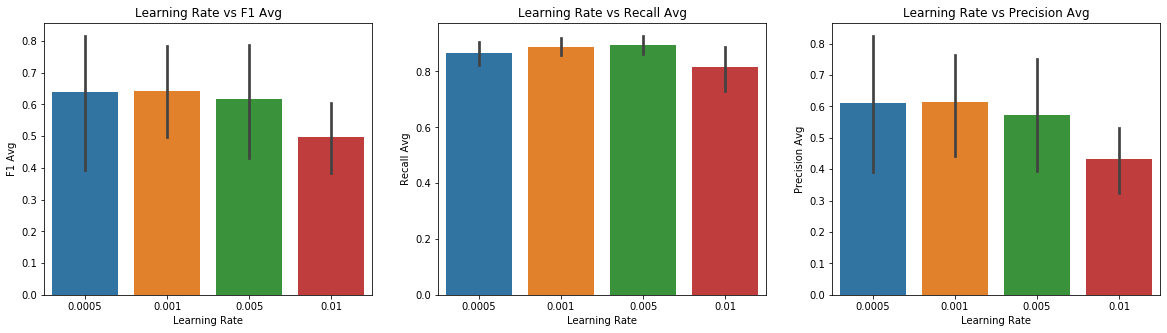

In [11]:
fig, ax = plt.subplots(ncols = 3, figsize = (20, 5))
sns.barplot(x = "Learning Rate", y = "F1 Avg", data = tuning_results, ax = ax[0])
ax[0].set_title("Learning Rate vs F1 Avg")
sns.barplot(x = "Learning Rate", y = "Recall Avg", data = tuning_results, ax = ax[1])
ax[1].set_title("Learning Rate vs Recall Avg")
sns.barplot(x = "Learning Rate", y = "Precision Avg", data = tuning_results, ax = ax[2])
ax[2].set_title("Learning Rate vs Precision Avg")
plt.show()

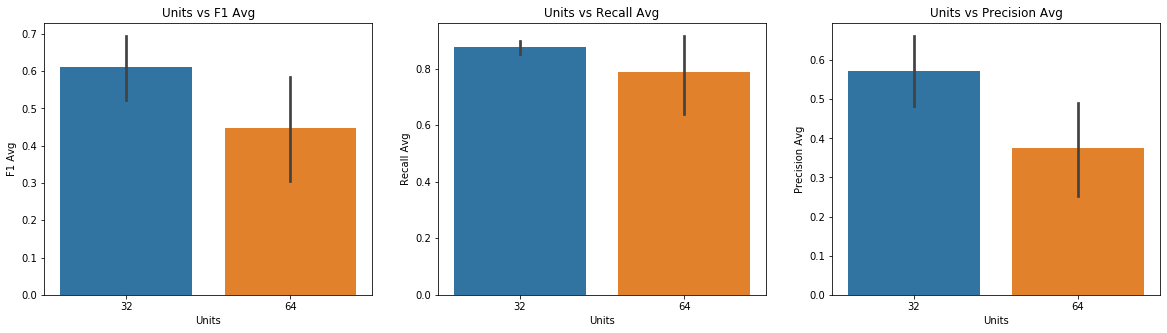

In [12]:
fig, ax = plt.subplots(ncols = 3, figsize = (20, 5))
sns.barplot(x = "Units", y = "F1 Avg", data = tuning_results, ax = ax[0])
ax[0].set_title("Units vs F1 Avg")
sns.barplot(x = "Units", y = "Recall Avg", data = tuning_results, ax = ax[1])
ax[1].set_title("Units vs Recall Avg")
sns.barplot(x = "Units", y = "Precision Avg", data = tuning_results, ax = ax[2])
ax[2].set_title("Units vs Precision Avg")
plt.show()

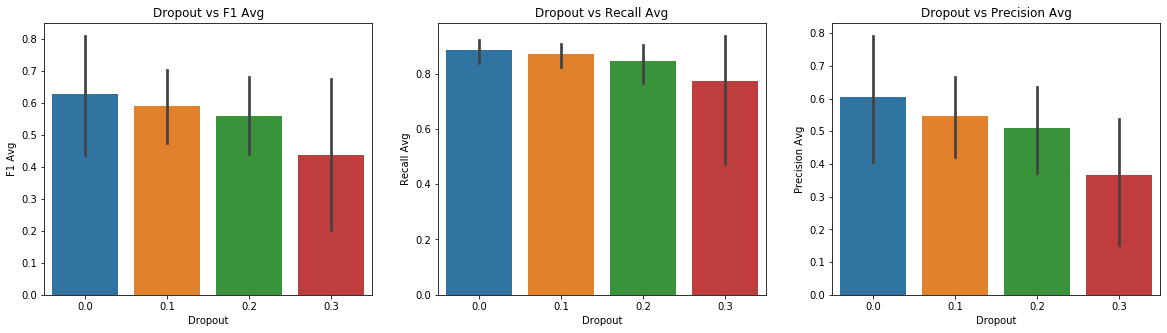

In [13]:
fig, ax = plt.subplots(ncols = 3, figsize = (20, 5))
sns.barplot(x = "Dropout", y = "F1 Avg", data = tuning_results, ax = ax[0])
ax[0].set_title("Dropout vs F1 Avg")
sns.barplot(x = "Dropout", y = "Recall Avg", data = tuning_results, ax = ax[1])
ax[1].set_title("Dropout vs Recall Avg")
sns.barplot(x = "Dropout", y = "Precision Avg", data = tuning_results, ax = ax[2])
ax[2].set_title("Dropout vs Precision Avg")
plt.show()

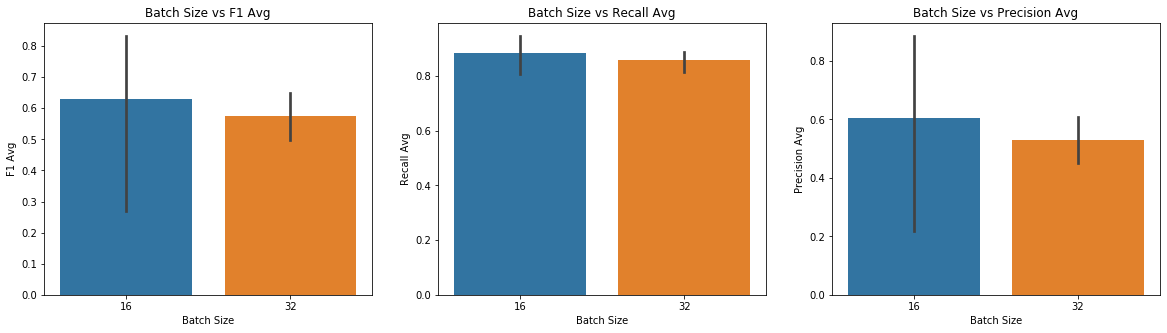

In [14]:
fig, ax = plt.subplots(ncols = 3, figsize = (20, 5))
sns.barplot(x = "Batch Size", y = "F1 Avg", data = tuning_results, ax = ax[0])
ax[0].set_title("Batch Size vs F1 Avg")
sns.barplot(x = "Batch Size", y = "Recall Avg", data = tuning_results, ax = ax[1])
ax[1].set_title("Batch Size vs Recall Avg")
sns.barplot(x = "Batch Size", y = "Precision Avg", data = tuning_results, ax = ax[2])
ax[2].set_title("Batch Size vs Precision Avg")

plt.show()

## VII. Sampling Performance Visualizations

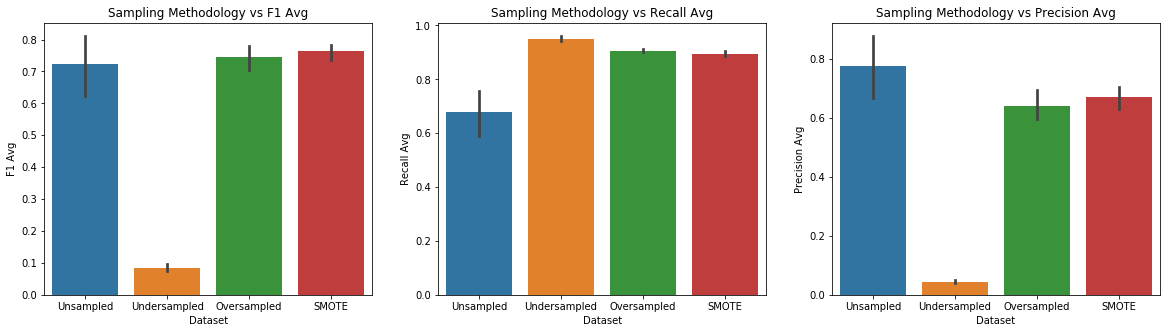

In [15]:
fig, ax = plt.subplots(ncols = 3, figsize = (20, 5))
sns.barplot(x = "Dataset", y = "F1 Avg", data = tuning_results, ax = ax[0])
ax[0].set_title("Sampling Methodology vs F1 Avg")
sns.barplot(x = "Dataset", y = "Recall Avg", data = tuning_results, ax = ax[1])
ax[1].set_title("Sampling Methodology vs Recall Avg")
sns.barplot(x = "Dataset", y = "Precision Avg", data = tuning_results, ax = ax[2])
ax[2].set_title("Sampling Methodology vs Precision Avg")

plt.show()

## VIII. Finding Optimal Hyperparameters and Sampling Methodology

In [16]:
tuning_results[tuning_results["F1 Avg"] == tuning_results["F1 Avg"].max()]

,Dataset,Learning Rate,Dropout,Units,Batch Size,F1 Avg,F1 Std,Recall Avg,Recall Std,Precision Avg,Precision Std,Accuracy Avg,Accuracy Std,Iterations
40,Unsampled,0.001,0.1,32,32,0.867076,0.038706,0.816,0.064992,0.930007,0.0449,0.999563,0.000121,5


In [17]:
tuning_results[tuning_results["Recall Avg"] == tuning_results["Recall Avg"].max()]

,Dataset,Learning Rate,Dropout,Units,Batch Size,F1 Avg,F1 Std,Recall Avg,Recall Std,Precision Avg,Precision Std,Accuracy Avg,Accuracy Std,Iterations
37,Undersampled,0.001,0.0,32,32,0.104473,0.009737,0.992,0.016,0.055167,0.005418,0.969747,0.003124,5


In [18]:
tuning_results[tuning_results["Precision Avg"] == tuning_results["Precision Avg"].max()]

,Dataset,Learning Rate,Dropout,Units,Batch Size,F1 Avg,F1 Std,Recall Avg,Recall Std,Precision Avg,Precision Std,Accuracy Avg,Accuracy Std,Iterations
56,Unsampled,0.001,0.1,32,16,0.847587,0.054736,0.776,0.096664,0.946894,0.043532,0.999521,0.000137,5


## IX. Final Models

In [19]:
# F1 model
unsampled_features = train_datasets_dict["Unsampled"].drop("label", axis = 1)
unsampled_labels = train_datasets_dict["Unsampled"]["label"]
f1_model_unsampled, f1_model_hist_unsampled = train_model(unsampled_features, unsampled_labels, None, None, lr = 0.001, dp = 0.1, units = 32, batch_size = 32, epochs = 20)

# F1 model2
smote_features = train_datasets_dict["SMOTE"].drop("label", axis = 1)
smote_labels = train_datasets_dict["SMOTE"]["label"]
f1_model_smote, f1_model_hist_smote = train_model(smote_features, smote_labels, None, None, lr = 0.001, dp = 0.1, units = 32, batch_size = 32, epochs = 20)

# Recall model
undersampled_features = train_datasets_dict["Undersampled"].drop("label", axis = 1)
undersampled_labels = train_datasets_dict["Undersampled"]["label"]
recall_model_undersampled, recall_model_hist_undersampled = train_model(undersampled_features, undersampled_labels, None, None, lr = 0.001, dp = 0.0, units = 32, batch_size = 32, epochs = 20)

In [20]:
# Computing predictions
f1_model_unsampled_preds = f1_model_unsampled.predict_classes(test_features)
f1_model_smote_preds = f1_model_smote.predict_classes(test_features)
recall_model_undersampled_preds = recall_model_undersampled.predict_classes(test_features)

# Printing scores
print("F1 model unsampled: {}".format(f1_score(test_labels, f1_model_unsampled_preds)))
print("F1 model smote: {}".format(f1_score(test_labels, f1_model_smote_preds)))
print("Recall model undersampled: {}".format(recall_score(test_labels, recall_model_undersampled_preds)))

F1 model unsampled: 0.8510638297872342
F1 model smote: 0.8214285714285714
Recall model undersampled: 1.0


In [21]:
# Saving models
f1_model_unsampled.save("../models/f1_model_unsampled.h5")
f1_model_smote.save("../models/f1_model_smote.h5")
recall_model_undersampled.save("../models/recall_model_undersampled.h5")